<a target="_blank" href="https://colab.research.google.com/github/spbisc97/GastroClassificator/blob/main/BaseVitImplementation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [33]:

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
from torchvision import transforms, datasets
import logging
from torch import nn # if you want to use the nn module for custom classification head
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn import metrics as mtc
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, ViTConfig
# if you want to use custom classification head
from transformers.modeling_outputs import CausalLMOutput,ImageClassifierOutput
from torch.cuda.amp import GradScaler, autocast
# from tqdm import tqdm
# if using the notebook
def is_notebook():
    try:
        from IPython import get_ipython
        shell = get_ipython().__class__.__name__
        if shell == "ZMQInteractiveShell":
            return True  # Jupyter notebook or qtconsole
        elif shell == "TerminalInteractiveShell":
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

if is_notebook():
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm



# from tqdm.notebook import tqdm

# Setting up the logger
logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Dataset directories
train_root_dir = "./DATASET/TRAIN"
val_root_dir = "./DATASET/VAL"
test_root_dir = "./DATASET/TEST"


INFO:root:Using device: cuda


In [34]:

# Load the feature extractor
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')


# Function to load datasets
def load_dataset(train_root_dir, val_root_dir, test_root_dir, transform=None,normalize=True, feature_extractor=feature_extractor):
    #if transform is None use the VitImageProcessor
    default_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    if transform is None:
        transform = default_transform
    if normalize:
        transform = transforms.Compose([
            transform,
            transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
            ])
        default_transform = transforms.Compose([
            default_transform,
            transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ])
    train_dataset = datasets.ImageFolder(train_root_dir, transform=transform)
    logger.info("Training dataset loaded with %d samples", len(train_dataset))
    val_dataset = datasets.ImageFolder(val_root_dir, transform=default_transform)
    logger.info("Validation dataset loaded with %d samples", len(val_dataset))
    test_dataset = datasets.ImageFolder(test_root_dir, transform=default_transform)
    logger.info("Test dataset loaded with %d samples", len(test_dataset))
    return train_dataset, val_dataset, test_dataset

# Function to get labels from dataset
def get_labels(dataset):
    return dataset.classes

# Function to calculate metrics
def calculate_metrics(outputs, targets):
    metrics = {
        "micro_precision": mtc.precision_score(outputs, targets, average="micro", zero_division=0),
        "micro_recall": mtc.recall_score(outputs, targets, average="micro", zero_division=0),
        "micro_f1": mtc.f1_score(outputs, targets, average="micro", zero_division=0),
        "macro_precision": mtc.precision_score(outputs, targets, average="macro", zero_division=0),
        "macro_recall": mtc.recall_score(outputs, targets, average="macro", zero_division=0),
        "macro_f1": mtc.f1_score(outputs, targets, average="macro", zero_division=0),
        "mcc": mtc.matthews_corrcoef(outputs, targets)
    }
    return metrics

# Function to compute evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return calculate_metrics(preds, labels)
    
# Custom collate function to handle the DataLoader output
def custom_collate_fn(batch):
    pixel_values = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Wrap DataLoader to be compatible with Trainer
class WrappedDataLoader:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for batch in self.dataloader:
            yield custom_collate_fn(batch)

    def __len__(self):
        return len(self.dataloader)

In [35]:

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(10, 10), font_size=12,save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams.update({'figure.autolayout': True})
    plt.rcParams.update({'figure.figsize': figsize})
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    


In [36]:

# Training arguments
metric_name = "micro_f1"
args = TrainingArguments(
    "test-GastroVision",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=1e-4,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='./logs',
    logging_steps=30,  # Log every 10 steps
    fp16=True,  # Enable mixed precision training if not using autoscaler 
)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.2), ratio=(0.75, 1.33)),  # Added stretch
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Load datasets
train_dataset, val_dataset, test_dataset = load_dataset(train_root_dir, val_root_dir, test_root_dir,transform=transform,normalize=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args.per_device_train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=args.per_device_eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=args.per_device_eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

INFO:root:Training dataset loaded with 4757 samples
INFO:root:Validation dataset loaded with 1587 samples
INFO:root:Test dataset loaded with 1586 samples


In [37]:
class CustomViTForImageClassification(ViTForImageClassification):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        # ... # add more layers if needed
        # ...
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        # ... # add more layers if needed
        # ...
        logits = self.classifier(outputs.last_hidden_state[:, 0])
        loss = nn.CrossEntropyLoss()(logits, labels)
        return CausalLMOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)
    
    
    
    

In [38]:
# Load the model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(get_labels(train_dataset)),attn_implementation='eager')
#model = CustomViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(get_labels(train_dataset)),attn_implementation='eager')
# Move the model to the appropriate device
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [39]:
# Define optimizer and learning rate scheduler for custom training loop
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4) #add verbose=True to see the learning rate change

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Custom training loop
def custom_train(trainer, model, train_loader,val_loader, optimizer, scheduler, scaler, device):
    model.train()
    total_loss = 0
    global_step = 0
    for epoch in range(trainer.args.num_train_epochs):
        for step, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            with autocast():
                outputs = model(pixel_values=images, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            global_step += 1

            if global_step % trainer.args.logging_steps == 0:
                avg_loss = total_loss / global_step
                tqdm.write(f"Step {global_step}, Loss: {avg_loss:.4f}")
                # logger.info(f"Step {global_step}, Loss: {avg_loss:.4f}") # Uncomment this line if you want to log the loss to the logger

        avg_loss = total_loss / (epoch + 1)
        logger.info(f"Epoch {epoch+1}/{trainer.args.num_train_epochs}, Train Loss: {avg_loss:.4f}")
        
        # Evaluate the model
        eval_results = trainer.evaluate(eval_dataset=val_loader.dataset)
        logger.info(f"Epoch {epoch+1}/{trainer.args.num_train_epochs}, Eval {eval_results}")
        if scheduler is not None:
            scheduler.step(eval_results["eval_loss"]) # ReduceLROnPlateau scheduler
            # scheduler.step() # StepLR scheduler
        
        


# Initialize the trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_loader.dataset,
    eval_dataset=val_loader.dataset,
    data_collator=custom_collate_fn,
    # data_collator=lambda x: {"pixel_values": torch.stack([item[0] for item in x]), "labels": torch.tensor([item[1] for item in x])},
    compute_metrics=compute_metrics,
)



In [40]:
# Train the model
# Train the model using the custom training loop
custom_train(trainer, model, train_loader, val_loader,optimizer, scheduler, scaler, device)
# trainer.train()

  0%|          | 0/298 [00:00<?, ?it/s]

Step 30, Loss: 2.8795
Step 60, Loss: 2.7211
Step 90, Loss: 2.6082
Step 120, Loss: 2.4936
Step 150, Loss: 2.3914
Step 180, Loss: 2.2958
Step 210, Loss: 2.2247
Step 240, Loss: 2.1500
Step 270, Loss: 2.0855


INFO:root:Epoch 1/10, Train Loss: 605.5541


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 1/10, Eval {'eval_loss': 1.4824399948120117, 'eval_micro_precision': 0.6868304977945809, 'eval_micro_recall': 0.6868304977945809, 'eval_micro_f1': 0.6868304977945809, 'eval_macro_precision': 0.3020888823163963, 'eval_macro_recall': 0.24863931850091409, 'eval_macro_f1': 0.26962029967569745, 'eval_mcc': 0.6462114863660791, 'eval_runtime': 10.7285, 'eval_samples_per_second': 147.924, 'eval_steps_per_second': 9.321}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 300, Loss: 2.0290
Step 330, Loss: 1.9776
Step 360, Loss: 1.9361
Step 390, Loss: 1.8912
Step 420, Loss: 1.8523
Step 450, Loss: 1.8114
Step 480, Loss: 1.7745
Step 510, Loss: 1.7379
Step 540, Loss: 1.7037
Step 570, Loss: 1.6729


INFO:root:Epoch 2/10, Train Loss: 491.3490


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 2/10, Eval {'eval_loss': 1.1436909437179565, 'eval_micro_precision': 0.7315689981096408, 'eval_micro_recall': 0.7315689981096408, 'eval_micro_f1': 0.7315689981096408, 'eval_macro_precision': 0.3785239281475933, 'eval_macro_recall': 0.4256504407257568, 'eval_macro_f1': 0.3618681571665046, 'eval_mcc': 0.6985040294486984, 'eval_runtime': 10.5126, 'eval_samples_per_second': 150.961, 'eval_steps_per_second': 9.512}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 600, Loss: 1.6444
Step 630, Loss: 1.6171
Step 660, Loss: 1.5864
Step 690, Loss: 1.5604
Step 720, Loss: 1.5372
Step 750, Loss: 1.5140
Step 780, Loss: 1.4922
Step 810, Loss: 1.4728
Step 840, Loss: 1.4527
Step 870, Loss: 1.4334


INFO:root:Epoch 3/10, Train Loss: 423.5262


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 3/10, Eval {'eval_loss': 0.9876875877380371, 'eval_micro_precision': 0.7611846250787649, 'eval_micro_recall': 0.7611846250787649, 'eval_micro_f1': 0.7611846250787649, 'eval_macro_precision': 0.47151191538893167, 'eval_macro_recall': 0.5140233835155202, 'eval_macro_f1': 0.45881287256362363, 'eval_mcc': 0.7342239625298641, 'eval_runtime': 10.8211, 'eval_samples_per_second': 146.658, 'eval_steps_per_second': 9.241}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 900, Loss: 1.4169
Step 930, Loss: 1.3985
Step 960, Loss: 1.3779
Step 990, Loss: 1.3602
Step 1020, Loss: 1.3426
Step 1050, Loss: 1.3272
Step 1080, Loss: 1.3113
Step 1110, Loss: 1.2959
Step 1140, Loss: 1.2796
Step 1170, Loss: 1.2651


INFO:root:Epoch 4/10, Train Loss: 374.3596


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 4/10, Eval {'eval_loss': 0.825661301612854, 'eval_micro_precision': 0.7958412098298677, 'eval_micro_recall': 0.7958412098298677, 'eval_micro_f1': 0.7958412098298677, 'eval_macro_precision': 0.49966078410160786, 'eval_macro_recall': 0.5620848220302492, 'eval_macro_f1': 0.49594766274653285, 'eval_mcc': 0.7705405608183069, 'eval_runtime': 10.7069, 'eval_samples_per_second': 148.222, 'eval_steps_per_second': 9.34}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 1200, Loss: 1.2520
Step 1230, Loss: 1.2373
Step 1260, Loss: 1.2250
Step 1290, Loss: 1.2117
Step 1320, Loss: 1.1976
Step 1350, Loss: 1.1855
Step 1380, Loss: 1.1730
Step 1410, Loss: 1.1617
Step 1440, Loss: 1.1489
Step 1470, Loss: 1.1370


INFO:root:Epoch 5/10, Train Loss: 336.5378


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 5/10, Eval {'eval_loss': 0.7926816344261169, 'eval_micro_precision': 0.7989918084436043, 'eval_micro_recall': 0.7989918084436043, 'eval_micro_f1': 0.7989918084436043, 'eval_macro_precision': 0.5421203229495694, 'eval_macro_recall': 0.5701559001460884, 'eval_macro_f1': 0.5413463879856943, 'eval_mcc': 0.7749441775541299, 'eval_runtime': 10.9479, 'eval_samples_per_second': 144.959, 'eval_steps_per_second': 9.134}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 1500, Loss: 1.1255
Step 1530, Loss: 1.1140
Step 1560, Loss: 1.1027
Step 1590, Loss: 1.0913
Step 1620, Loss: 1.0804
Step 1650, Loss: 1.0699
Step 1680, Loss: 1.0599
Step 1710, Loss: 1.0499
Step 1740, Loss: 1.0401
Step 1770, Loss: 1.0310


INFO:root:Epoch 6/10, Train Loss: 305.8024


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 6/10, Eval {'eval_loss': 0.7203031182289124, 'eval_micro_precision': 0.8097038437303088, 'eval_micro_recall': 0.8097038437303088, 'eval_micro_f1': 0.8097038437303088, 'eval_macro_precision': 0.5609234569200127, 'eval_macro_recall': 0.5743512270224765, 'eval_macro_f1': 0.5594312920175535, 'eval_mcc': 0.7866674981779569, 'eval_runtime': 10.8928, 'eval_samples_per_second': 145.692, 'eval_steps_per_second': 9.18}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 1800, Loss: 1.0225
Step 1830, Loss: 1.0120
Step 1860, Loss: 1.0028
Step 1890, Loss: 0.9933
Step 1920, Loss: 0.9840
Step 1950, Loss: 0.9758
Step 1980, Loss: 0.9675
Step 2010, Loss: 0.9590
Step 2040, Loss: 0.9509
Step 2070, Loss: 0.9436


INFO:root:Epoch 7/10, Train Loss: 279.9342


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 7/10, Eval {'eval_loss': 0.680510401725769, 'eval_micro_precision': 0.8235664776307499, 'eval_micro_recall': 0.8235664776307499, 'eval_micro_f1': 0.8235664776307499, 'eval_macro_precision': 0.6118261689840738, 'eval_macro_recall': 0.6340698167640273, 'eval_macro_f1': 0.5972223330472398, 'eval_mcc': 0.8028472391746346, 'eval_runtime': 10.9721, 'eval_samples_per_second': 144.64, 'eval_steps_per_second': 9.114}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 2100, Loss: 0.9356
Step 2130, Loss: 0.9272
Step 2160, Loss: 0.9185
Step 2190, Loss: 0.9110
Step 2220, Loss: 0.9042
Step 2250, Loss: 0.8958
Step 2280, Loss: 0.8885
Step 2310, Loss: 0.8814
Step 2340, Loss: 0.8751
Step 2370, Loss: 0.8683


INFO:root:Epoch 8/10, Train Loss: 257.9040


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 8/10, Eval {'eval_loss': 0.7006115913391113, 'eval_micro_precision': 0.8128544423440454, 'eval_micro_recall': 0.8128544423440454, 'eval_micro_f1': 0.8128544423440454, 'eval_macro_precision': 0.5804619703165105, 'eval_macro_recall': 0.642427149987626, 'eval_macro_f1': 0.5863271241278531, 'eval_mcc': 0.7901498895723276, 'eval_runtime': 11.4132, 'eval_samples_per_second': 139.049, 'eval_steps_per_second': 8.762}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 2400, Loss: 0.8617
Step 2430, Loss: 0.8548
Step 2460, Loss: 0.8474
Step 2490, Loss: 0.8407
Step 2520, Loss: 0.8345
Step 2550, Loss: 0.8282
Step 2580, Loss: 0.8215
Step 2610, Loss: 0.8144
Step 2640, Loss: 0.8087
Step 2670, Loss: 0.8028


INFO:root:Epoch 9/10, Train Loss: 238.5332


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 9/10, Eval {'eval_loss': 0.6798180341720581, 'eval_micro_precision': 0.8172652804032766, 'eval_micro_recall': 0.8172652804032766, 'eval_micro_f1': 0.8172652804032766, 'eval_macro_precision': 0.6312295964961062, 'eval_macro_recall': 0.6671723996857122, 'eval_macro_f1': 0.6363865708291385, 'eval_mcc': 0.7952092081294027, 'eval_runtime': 10.8289, 'eval_samples_per_second': 146.552, 'eval_steps_per_second': 9.235}


  0%|          | 0/298 [00:00<?, ?it/s]

Step 2700, Loss: 0.7965
Step 2730, Loss: 0.7908
Step 2760, Loss: 0.7845
Step 2790, Loss: 0.7782
Step 2820, Loss: 0.7725
Step 2850, Loss: 0.7673
Step 2880, Loss: 0.7621
Step 2910, Loss: 0.7563
Step 2940, Loss: 0.7511
Step 2970, Loss: 0.7460


INFO:root:Epoch 10/10, Train Loss: 221.8586


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Epoch 10/10, Eval {'eval_loss': 0.7142701745033264, 'eval_micro_precision': 0.8084436042848141, 'eval_micro_recall': 0.8084436042848141, 'eval_micro_f1': 0.8084436042848141, 'eval_macro_precision': 0.6225833598677248, 'eval_macro_recall': 0.7145896606696085, 'eval_macro_f1': 0.6354348027006189, 'eval_mcc': 0.7857595343760823, 'eval_runtime': 11.0529, 'eval_samples_per_second': 143.582, 'eval_steps_per_second': 9.047}


In [41]:


# Evaluate the model on the test dataset
test_results = trainer.evaluate(eval_dataset=test_loader.dataset)
logger.info(f"Test results: {test_results}")

# Generate predictions for the test dataset
preds_output = trainer.predict(test_loader.dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Calculate and log the confusion matrix
conf_matrix = confusion_matrix(labels, preds)
logger.info(f"Confusion Matrix:\n{conf_matrix}")


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Test results: {'eval_loss': 0.6852408647537231, 'eval_micro_precision': 0.8184110970996217, 'eval_micro_recall': 0.8184110970996217, 'eval_micro_f1': 0.8184110970996217, 'eval_macro_precision': 0.6052284081227038, 'eval_macro_recall': 0.7045613768448152, 'eval_macro_f1': 0.617463824663394, 'eval_mcc': 0.7969052273041086, 'eval_runtime': 10.7546, 'eval_samples_per_second': 147.472, 'eval_steps_per_second': 9.298}


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Confusion Matrix:
[[244   0   1   0   0   2   1   0   0   0   0   0   0   0   0   0   2   0
    0   3   0   0]
 [  0   5   0   0   0   0   0   0   0   0   0   0  11   0   0   3   0   0
    0   0   0   0]
 [  0   0  32   0   0   1   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0]
 [  0   0   0   6   0   0   0   0   0   0   0   0   0   0   0   0  17   0
    0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   5   0
    0   0   0   0]
 [  2   0   1   0   0 131   4   0   0   0   0   1   0   1   0   0  21   1
    1   0   0   0]
 [  0   0   4   0   0   7  14   0   1   0   0   0   0   0   0   0   1   0
    0   1   0   0]
 [  0   0   0   0   0   0   0  30   0   0   0   0   1   0   0   0   0   1
    2   0   0   7]
 [  2   0   0   0   0   1   0   0  25   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   5  44   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 

Confusion matrix, without normalization


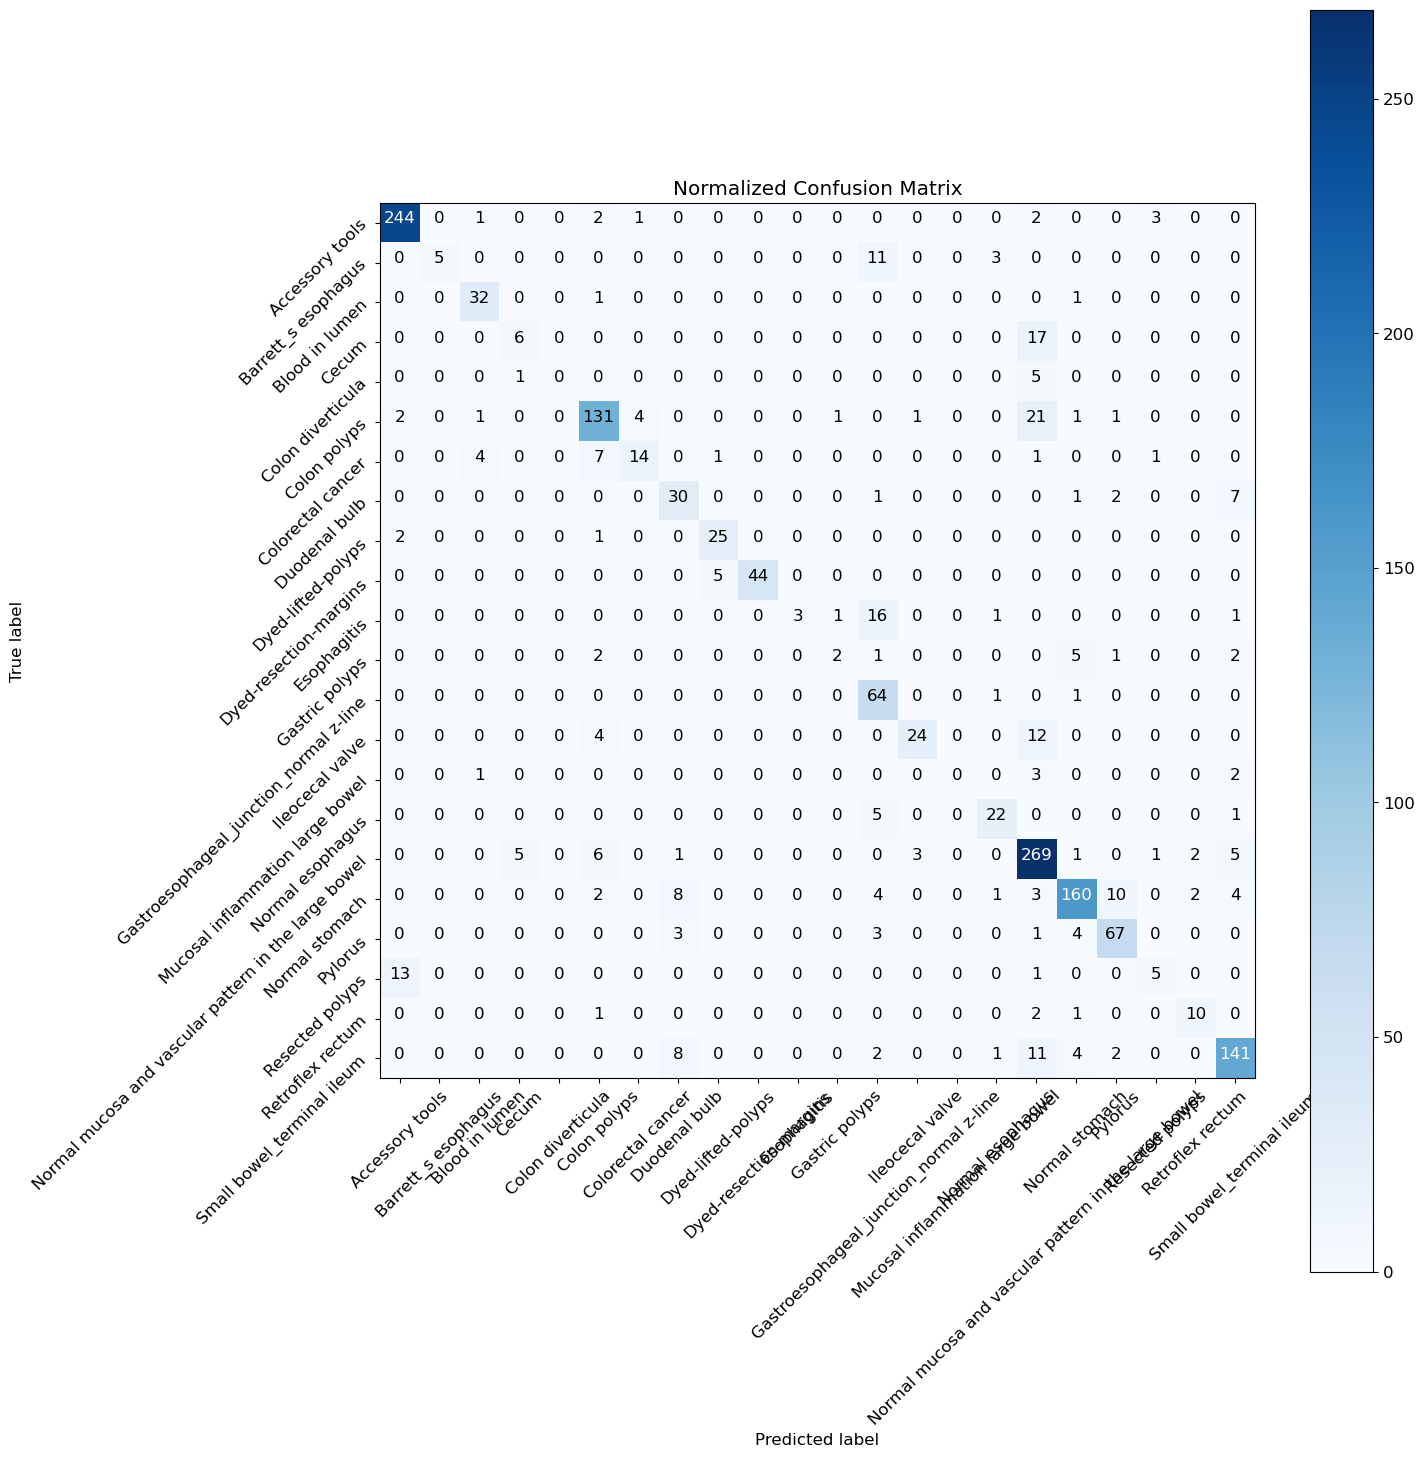

In [42]:

plot_confusion_matrix(conf_matrix, get_labels(test_dataset), normalize=False, title="Normalized Confusion Matrix", figsize=(15, 15),font_size=12)

plt.show()
# %%

#convert to notebook
# ipynb-py-convert BaseVitImplementation.py BaseVitImplementation.ipynb
# or the other way around
# ipynb-py-convert BaseVitImplementation.ipynb BaseVitImplementation.py